## A brief introduction and background about AI4PDEs

The AI4PDEs code solves discretised systems with untrained neural networks. It is used to simulate incompressible Navier-Stokes equations which can be written in 2D as, 
$$
\frac{\partial \mathbf{q}}{\partial t} + u\frac{\partial \mathbf{q}}{\partial x} +  v\frac{\partial \mathbf{q}}{\partial y} + 
\sigma \mathbf{q} - \nu \nabla \cdot \nabla \mathbf{q} = -\nabla p \,
$$

$$
\nabla  \cdot \mathbf{q} = \mathbf{0} \,
$$
in which $\mathbf{q}=(u \;v)^T$ in 2D and $\mathbf{q}=(u\;v\;w)^T$ in 3D, $p$ is the pressure, $\sigma$ is an absorption term and $\nu$ is the viscosity coefficient. A projection based solution method formed by manipulating the 
discretised equations which results in the following procedure,
1. Solve for $\mathbf{q}^{n+1}$ using the two-step approach outlined for the Burgers and advection-diffusion equation but treating the term involving $\sigma$ fully implicitly:
$$
\frac{\mathbf{q}^{n+1} -\mathbf{q}^{n} }{\Delta t} + u^n\frac{\partial \mathbf{q}^{n+\frac{1}{2}} }{\partial x} +  v^n\frac{\partial \mathbf{q}^{n+\frac{1}{2}} }{\partial y} + 
\sigma \mathbf{q}^{n+1} - \nu \nabla \cdot \nabla \mathbf{q}^{n+\frac{1}{2}} = -\nabla p^n \,
$$
2. Solve for pressure correction $\Delta p$:
$$ 
\nabla^2 \Delta p = -\frac{1}{\Delta t} \nabla \cdot \mathbf{q}^{n+1}  
$$
3. Solve for the velocity correction $\Delta \mathbf{q}$ using the U-net structured multigrid solver
$$
\Delta \mathbf{q} = -\Delta t \nabla \Delta p. 
$$
4. Update pressure solution: $p^{n+1} = p^n + \Delta p$
5. Update velocity solution: $\mathbf{q}^{n+1} \leftarrow \mathbf{q}^{n+1} + \Delta \mathbf{q}$

## More details can be found in our recent publications,
+
Phillips TR, Heaney CE, Chen B, Buchan AG, Pain CC. [Solving the discretised neutron diffusion equations using neural networks](https://doi.org/10.1002/nme.7321). International Journal for Numerical Methods in Engineering. 2023 Nov 15;124(21):4659-86. 
+
Phillips TR, Heaney CE, Chen B, Buchan AG, Pain CC. [Solving the Discretised Boltzmann Transport Equations using Neural Networks: Applications in Neutron Transport](https://doi.org/10.48550/arXiv.2301.09991). arXiv preprint arXiv:2301.09991. 2023 Jan 24. 
+
Chen B, Heaney CE, Pain CC. [Using AI libraries for Incompressible Computational Fluid Dynamics](https://doi.org/10.48550/arXiv.2402.17913). arXiv preprint arXiv:2402.17913. 2024 Feb 27. 
+
Chen B, Heaney CE, Gomes JL, Matar OK, Pain CC. [Solving the Discretised Multiphase Flow Equations with Interface Capturing on Structured Grids Using Machine Learning Libraries]( https://doi.org/10.1016/j.cma.2024.116974). Computer Methods in Applied Mechanics and Engineering. 2024 June 1; 426: 0045-7825.

Contact: Prof Christopher C. Pain (c.pain@imperial.ac.uk), Dr Claire E. Heaney (c.heaney@imperial.ac.uk), Dr Boyang Chen (boyang.chen16@imperial.ac.uk). [Applied Modelling and Computation Group](https://www.imperial.ac.uk/earth-science/research/research-groups/amcg/), Department of Earth Science and Engineering, Imperial College London

## Load modules from Python/Pytorch

In [16]:
import os
import numpy as np 
import torch
import matplotlib.pyplot as plt


import ai4pdes
from ai4pdes.models import FlowPastBlock, Block


# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(is_gpu, device)

False cpu


## Create grid
The first step is to create our domain on a grid. We will use the default settings with domain size `nx=254`, `ny=62`. 

In [17]:
from ai4pdes.grid import Grid
grid = Grid(nx=254, ny=62)
print(grid)

## Create a block
We can create a custom block that lives in the grid and provide the position and size of the block.

In [60]:
block = Block(grid, cor_x=126, cor_y=30, size_x=30, size_y=10)


A bluff body has been created successfully!
Size of body in x: 60
Size of body in y: 20
position of body in x: 126
position of body in y: 30


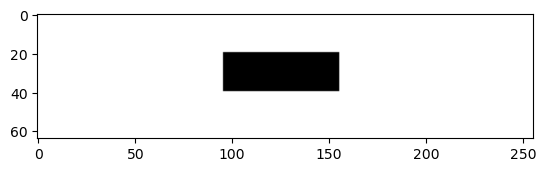

In [52]:
## Visualise the block
plt.imshow(block.sigma[0,0,:,:].cpu(), cmap='gray_r')


## Create model
Create an instance of the model. We are using the `FlowPastBlock` model. It requires information about the grid, the block. 

In [53]:
model = FlowPastBlock(grid, block)
print(model)

All the required 2D filters have been created successfully!
w1    => second order derivative  - (1,1,3,3)
w2    => first order derivative x - (1,1,3,3)
w3    => first order derivative y - (1,1,3,3)
wA    => second order derivative  - (1,1,3,3)
w_res => Restriction operation    - (1,1,3,3)
diag  => Diagonal component of wA - (1,1,1,1)


## Create a simulation
Our simulation will contain information about model and the variables within our model.

In [54]:
simulation = model.initialize()
print(simulation)

In [55]:
print(simulation.prognostic_variables)
print(simulation.diagnostic_variables)
print(simulation.model)

## Run the model

In [56]:
simulation.run(ntimesteps=1000)


Time step: 100 Pressure residual: 0.00000
Time step: 200 Pressure residual: 0.00000
Time step: 300 Pressure residual: 0.00000
Time step: 400 Pressure residual: 0.00000
Time step: 500 Pressure residual: 0.00000
Time step: 600 Pressure residual: 0.00000
Time step: 700 Pressure residual: 0.00000
Time step: 800 Pressure residual: 0.00000
Time step: 900 Pressure residual: 0.00000
Time step: 1000 Pressure residual: 0.00000
Elapsed time: 5.832175016403198


## Plot the results

In [57]:
simulation.prognostic_variables.u

tensor([[[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [-1.,  0.,  0.,  ...,  0.,  0., -1.],
          [-1.,  0.,  0.,  ...,  0.,  0., -1.],
          ...,
          [-1.,  0.,  0.,  ...,  0.,  0., -1.],
          [-1.,  0.,  0.,  ...,  0.,  0., -1.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]]])

In [58]:
from ai4pdes.plot_state import plot_u, plot_v

plot_u(prognostic_variables)
plt.show()

ModuleNotFoundError: No module named 'ai4pdes.plot_state'

In [59]:
plot_v(prognostic_variables)
plt.show()

NameError: name 'plot_v' is not defined